In [331]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

In [332]:
dirname = os.path.abspath(os.curdir) + r'\data'
lake_ds = pd.read_csv(path.join(os.sep, dirname, 'dataset.csv')) # Читаем .csv файл, в которо содержаьтся данные с годовым количеством осадков в озере Верхнее с 1900 по 1986 год
lake_ds.set_index('Year').sort_index()
df = lake_ds.copy()

In [333]:
df.head()

,Year,x
0,1,28.55
1,2,27.37
2,3,25.60
3,4,29.93
4,5,27.61


### Скользящее среднее

In [334]:
df['MA_window_3'] = df['x'].rolling(window=3).mean()
df

,Year,x,MA_window_3
0,1,28.55,NaN
1,2,27.37,NaN
2,3,25.60,27.173333
3,4,29.93,27.633333
4,5,27.61,27.713333
...,...,...,...
82,83,35.82,31.260000
83,84,32.27,32.153333
84,85,29.09,32.393333
85,86,38.25,33.203333


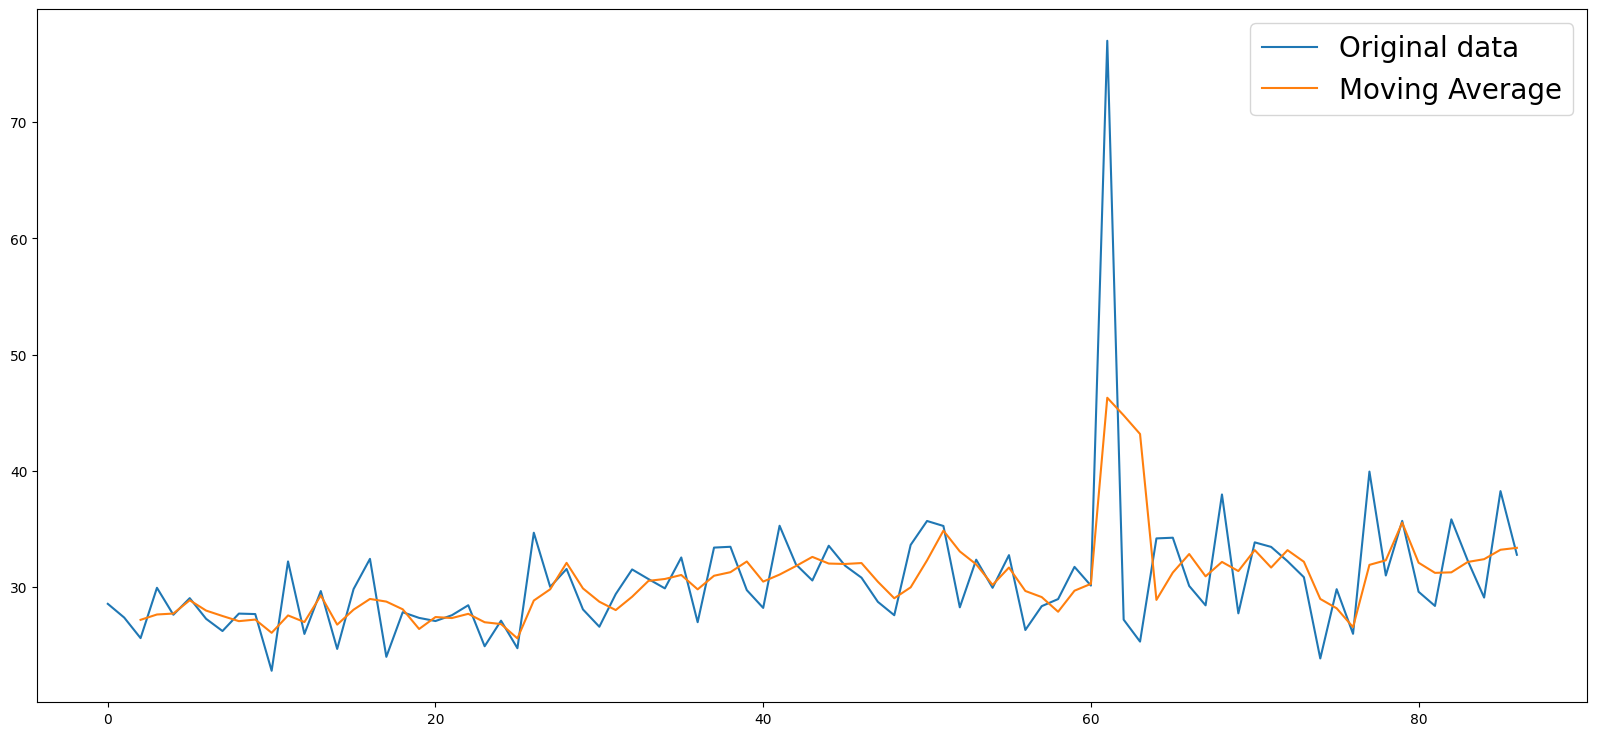

In [335]:
fig = plt.figure(figsize=(20, 9))
plt.plot(df['x'], label='Original data')
plt.plot(df['MA_window_3'], label='Moving Average')
plt.legend(fontsize="20")
plt.show()

### ARMA

In [336]:
from statsmodels.tsa.arima.model import ARIMA

In [337]:
size = int(len(df)*0.8)
X = df['x'].values
train, test = X[:size], X[size+1:]

In [338]:
%%capture
history = [x for x in train]
arma_predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arma_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

#### Метрики

In [339]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

f_pred = arma_predictions

print('RMSE:', np.sqrt(mean_squared_error(test, f_pred)))
print('MAPE:', mean_absolute_percentage_error(test, f_pred))
print('MAE:', mean_absolute_error(test, f_pred))
print('R2:', r2_score(test, f_pred))

RMSE: 4.317497376343499
MAPE: 0.1041604338707948
MAE: 3.389975290243854
R2: -0.15796246475996067


In [340]:
history = [x for x in train]
arima_predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [341]:
f_pred = arima_predictions

print('RMSE:', np.sqrt(mean_squared_error(test, f_pred)))
print('MAPE:', mean_absolute_percentage_error(test, f_pred))
print('MAE:', mean_absolute_error(test, f_pred))
print('R2:', r2_score(test, f_pred))

RMSE: 4.211678173179487
MAPE: 0.10790157065160151
MAE: 3.305200390689864
R2: -0.10189616979654992


### Работа с пропусками

In [342]:
GAP_START = 55
GAP_FINISH = 62 
# Процедура для печати графика
def print_plot(old_df, new_df, title=""):
    fig = plt.figure(figsize=(20, 9))
    plt.plot(old_df['x'], label='Data original')
    plt.plot(new_df['x'])
    plt.legend(fontsize="20")
    plt.title(title)
    plt.show()

C:\Users\danon\AppData\Local\Temp\ipykernel_3332\1439702882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nw_df['x'][GAP_START:GAP_FINISH] = np.nan


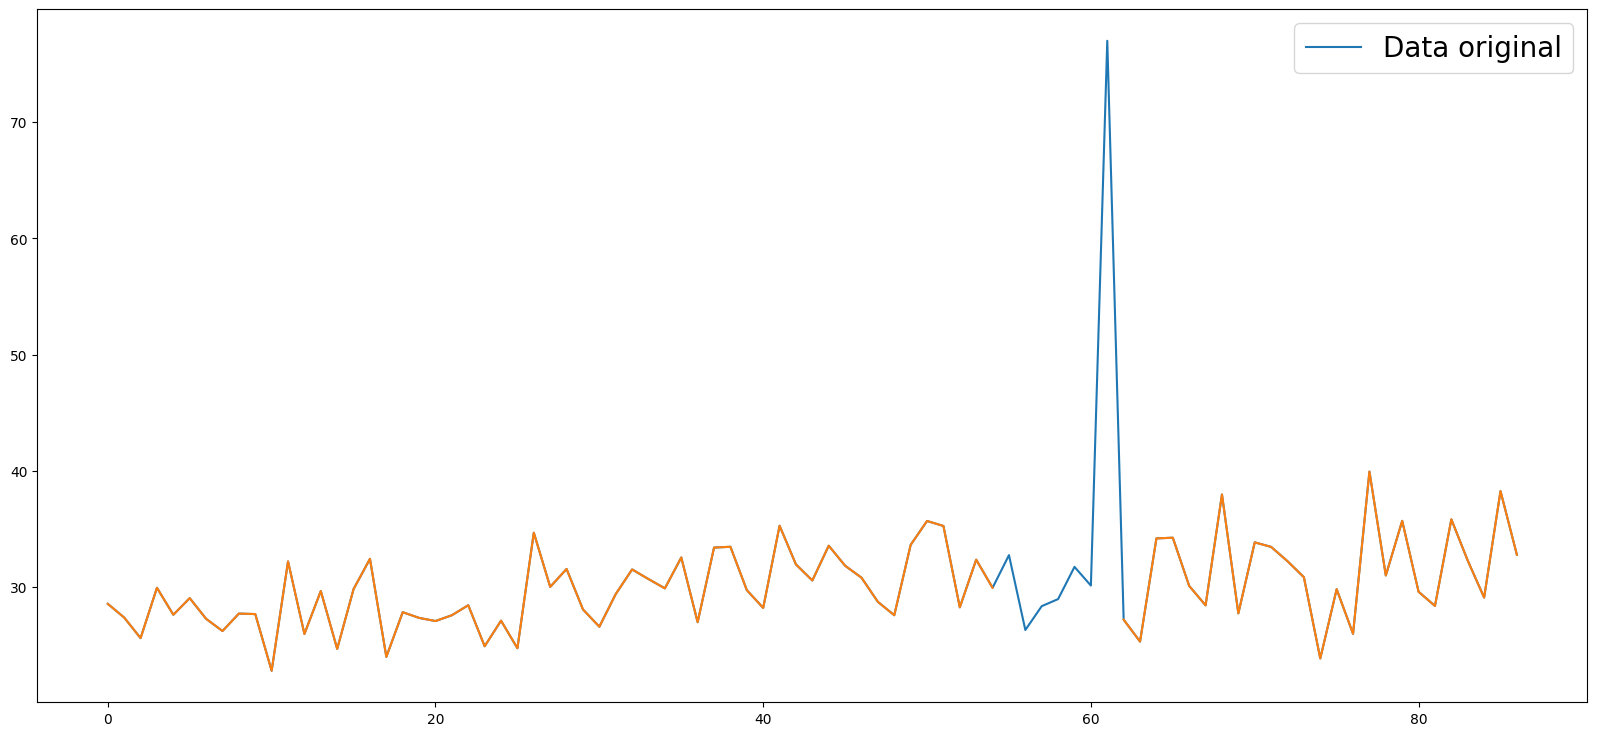

In [343]:
nw_df = lake_ds.copy()
nw_df['x'][GAP_START:GAP_FINISH] = np.nan
print_plot(lake_ds, nw_df)

#### Заполнение предыдущим и последующим значениями​

C:\Users\danon\AppData\Local\Temp\ipykernel_3332\127162008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nw_df['x'][GAP_START:GAP_FINISH] = new_value


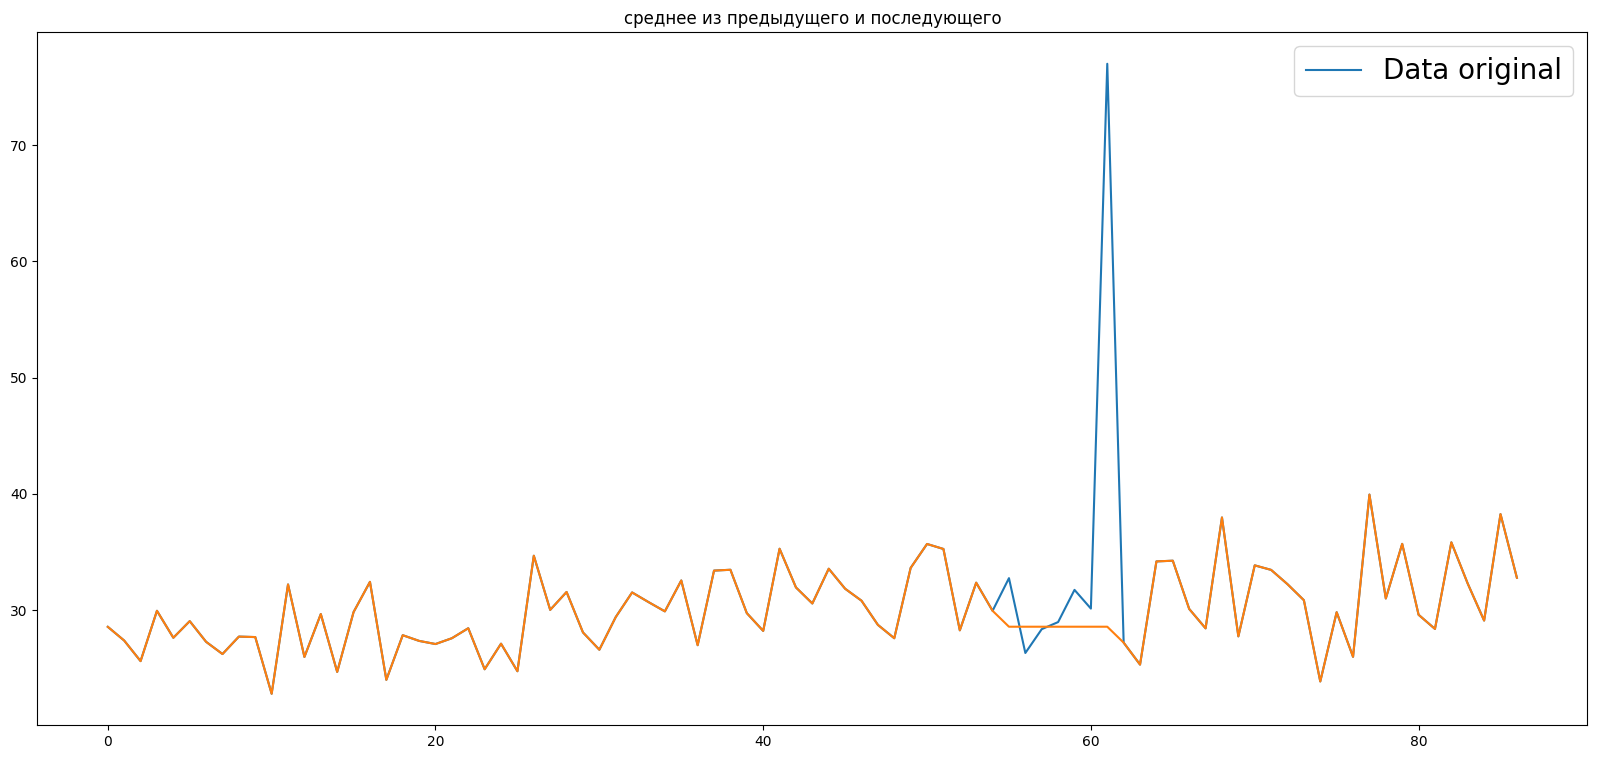

In [344]:
new_value = (nw_df['x'][GAP_FINISH] + nw_df['x'][GAP_START - 1])/2
nw_df['x'][GAP_START:GAP_FINISH] = new_value
print_plot(lake_ds, nw_df, 'среднее из предыдущего и последующего')

C:\Users\danon\AppData\Local\Temp\ipykernel_3332\1491381306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nw_df['x'][GAP_START:GAP_FINISH] = new_value


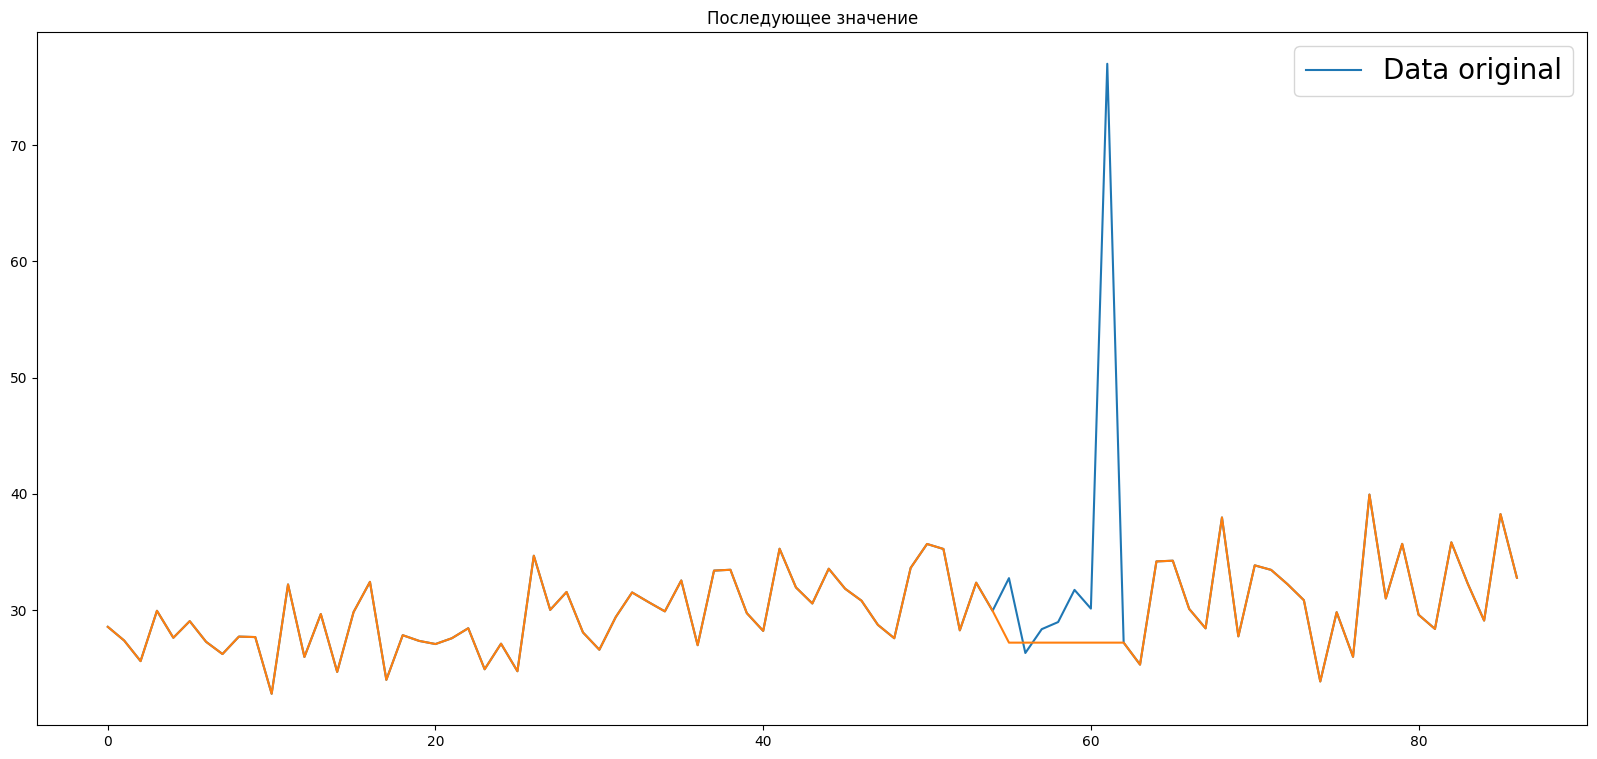

In [345]:
new_value = nw_df['x'][GAP_FINISH]
nw_df['x'][GAP_START:GAP_FINISH] = new_value
print_plot(lake_ds, nw_df, 'Последующее значение')

C:\Users\danon\AppData\Local\Temp\ipykernel_3332\3777993539.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nw_df['x'][GAP_START:GAP_FINISH] = new_value


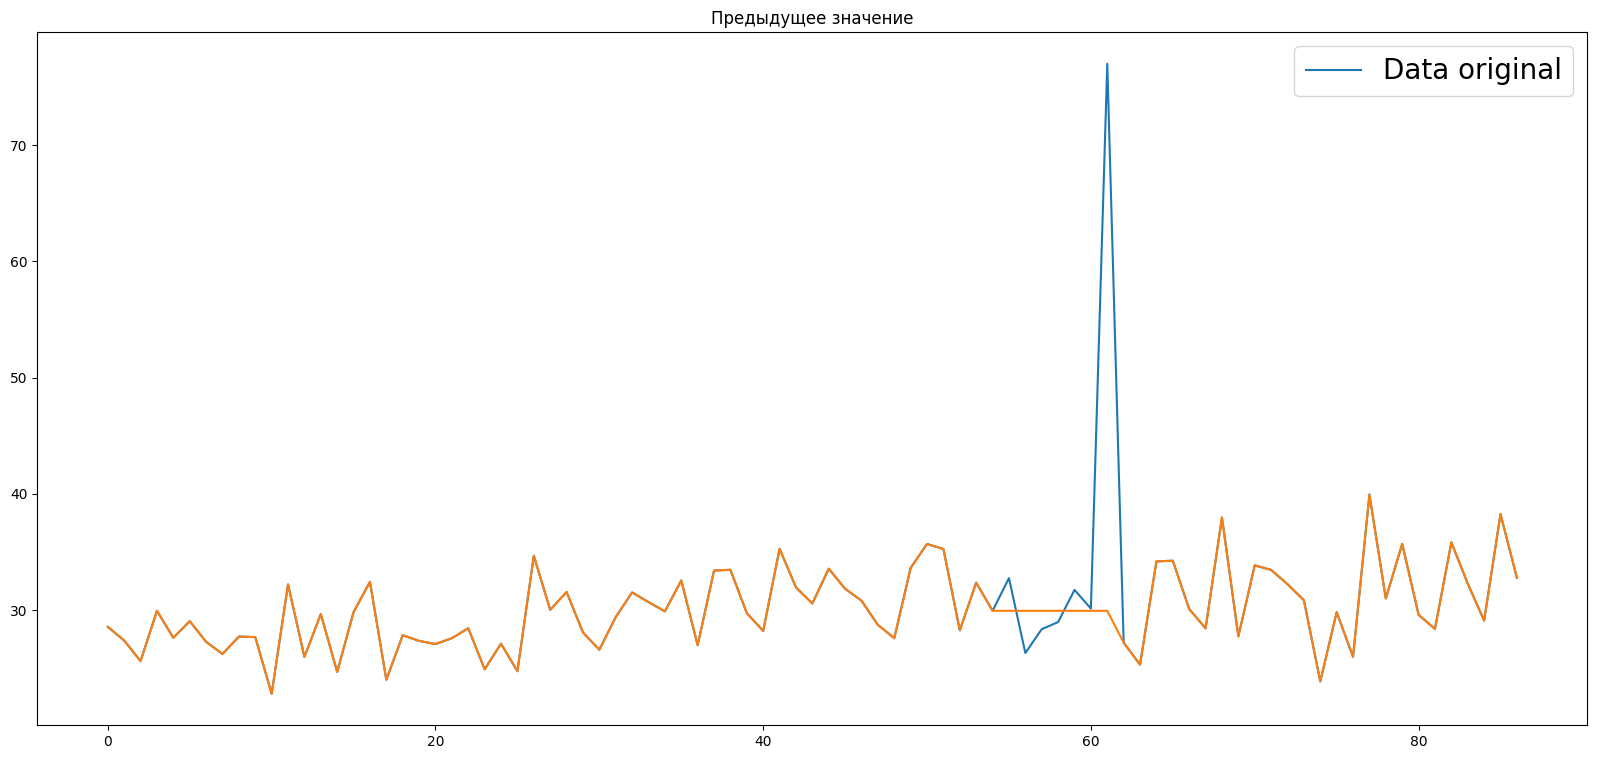

In [346]:
new_value = nw_df['x'][GAP_START-1]
nw_df['x'][GAP_START:GAP_FINISH] = new_value
print_plot(lake_ds, nw_df, 'Предыдущее значение')

#### Заполнение скользящим средним и медианой​

C:\Users\danon\AppData\Local\Temp\ipykernel_3332\765208873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nw_df['x'][GAP_START:GAP_FINISH] = new_value


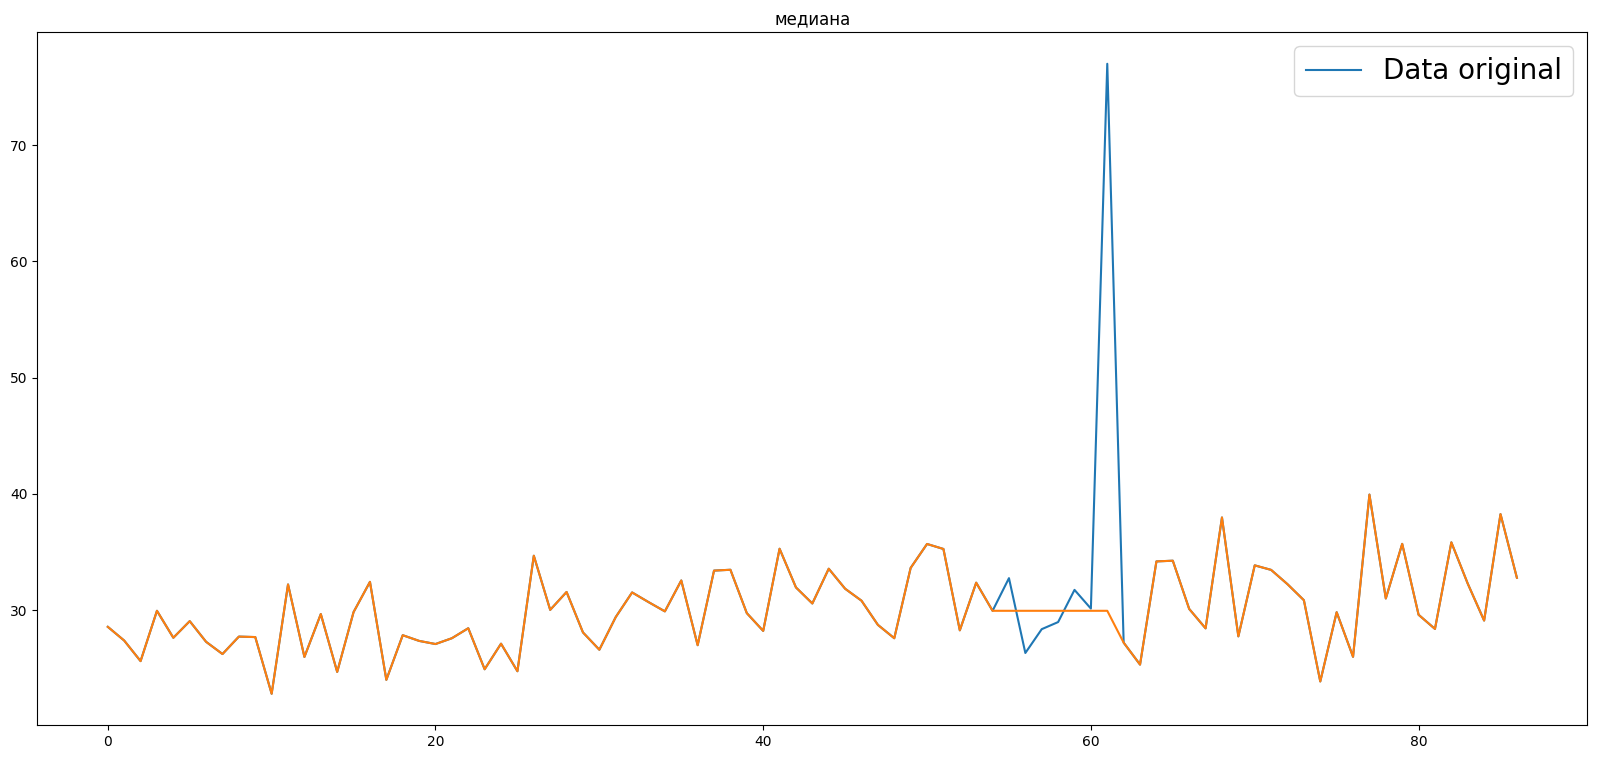

In [347]:
new_value = nw_df['x'].median()
nw_df['x'][GAP_START:GAP_FINISH] = new_value
print_plot(lake_ds, nw_df, 'медиана')

C:\Users\danon\AppData\Local\Temp\ipykernel_3332\1994417917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nw_df['x'][GAP_START:GAP_FINISH] = new_value


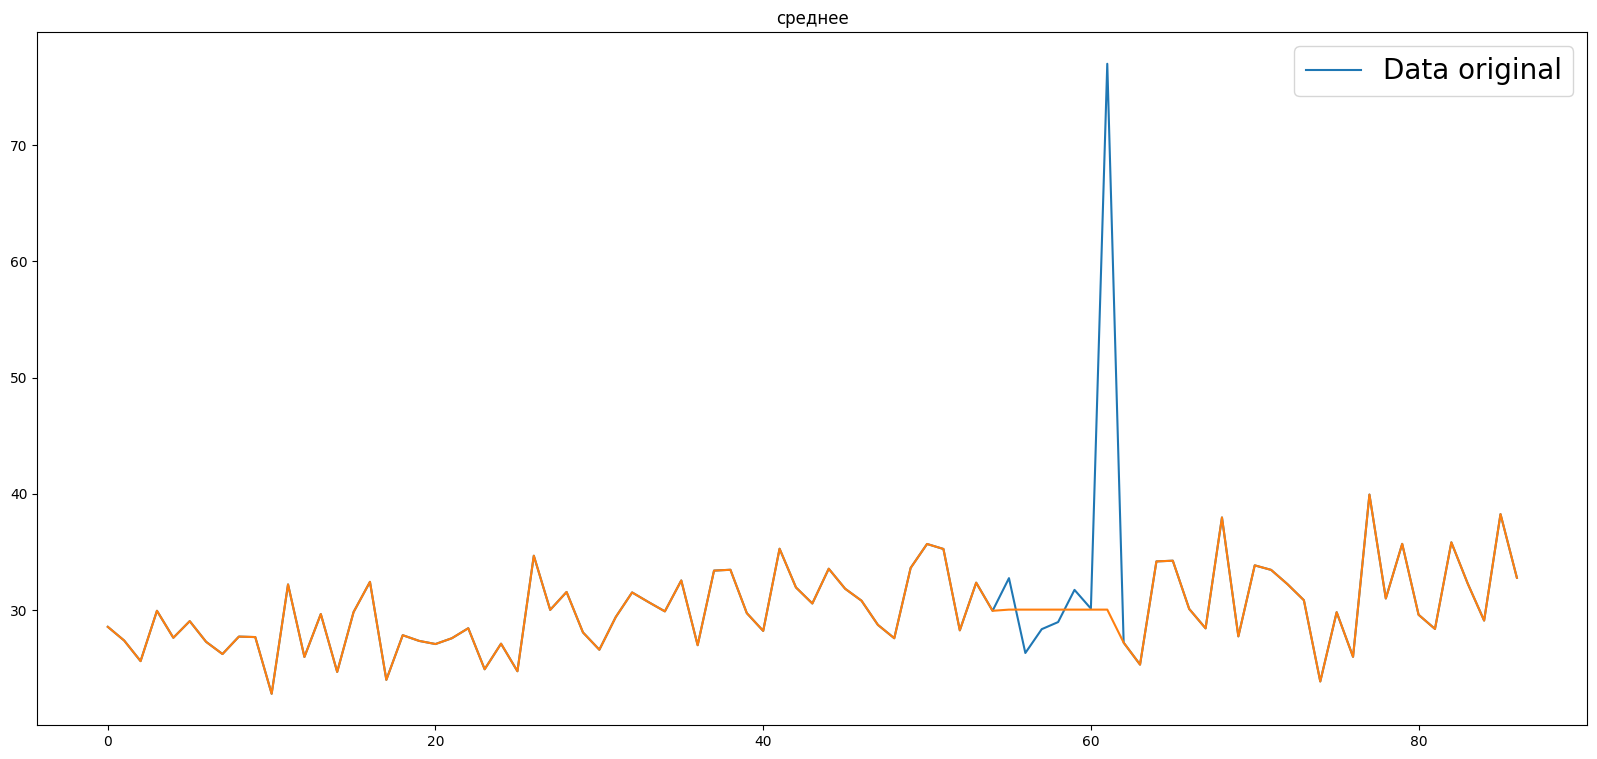

In [348]:
new_value = nw_df['x'].mean()
nw_df['x'][GAP_START:GAP_FINISH] = new_value
print_plot(lake_ds, nw_df, 'среднее')

#### Интерполяция

C:\Users\danon\AppData\Local\Temp\ipykernel_3332\3669189888.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nw_df['x'][GAP_START:GAP_FINISH] = np.nan


<Axes: title={'center': 'zero'}>

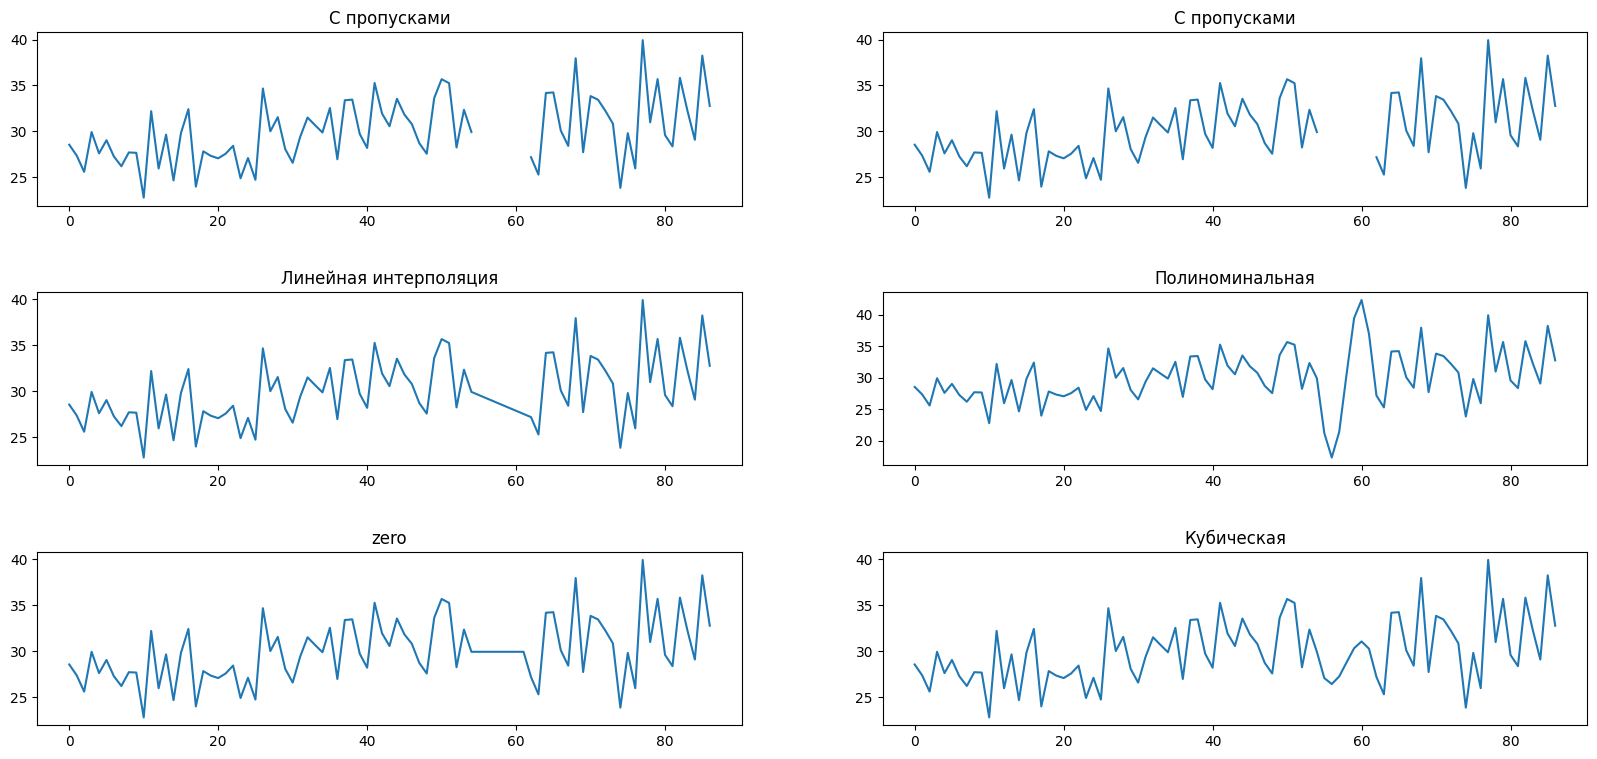

In [349]:
nw_df['x'][GAP_START:GAP_FINISH] = np.nan
nw_df = nw_df['x']

lin_df = nw_df.interpolate(method="linear")

cub_df = nw_df.interpolate(method="cubic")

pol_df = nw_df.interpolate(method="polynomial", order=5)

zero_df = nw_df.interpolate(method="zero")


fig = plt.figure(figsize=(20, 9))
layout = (3, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

original_ax = plt.subplot2grid(layout, (0, 0))
lin_ax = plt.subplot2grid(layout, (1, 0))
cub_ax = plt.subplot2grid(layout, (2, 1))

pol_ax = plt.subplot2grid(layout, (1, 1))
zero_ax = plt.subplot2grid(layout, (2, 0))

nw_df.plot(title="С пропусками", ax = original_ax)
nw_df.plot(title="С пропусками", ax = plt.subplot2grid(layout, (0, 1)))  
lin_df.plot(title="Линейная интерполяция", ax = lin_ax) 
cub_df.plot(title="Кубическая", ax = cub_ax) 
pol_df.plot(title="Полиноминальная", ax = pol_ax) 
zero_df.plot(title="zero", ax=zero_ax)

### Поиск выбросов

Т.к. в исходном датасете не было обнаружено выбросов, то я добавил их руками

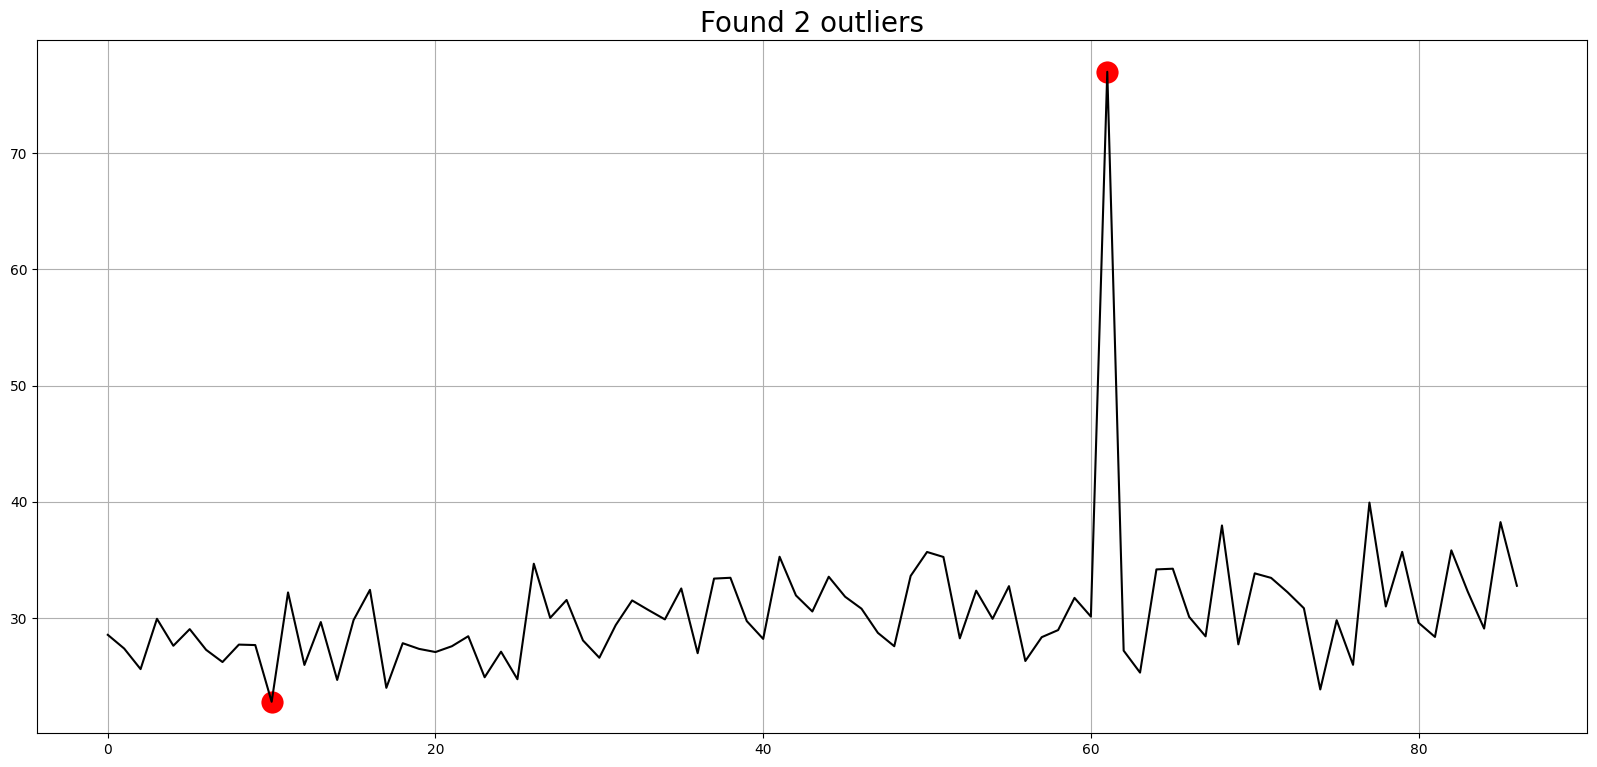

In [350]:
# Поиск выбросов
import seaborn as sns
from sklearn import preprocessing, svm
scaler = preprocessing.StandardScaler()
perc = 0.01

ecg = lake_ds.copy()

local_df = ecg["x"]

ts_scaled = scaler.fit_transform(local_df.values.reshape(-1,1))
model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
model.fit(ts_scaled)

dtf_outliers = local_df.to_frame(name="ts")
dtf_outliers["index"] = range(len(local_df))
dtf_outliers["outlier"] = model.predict(ts_scaled)
dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda x: 1 if x==-1 else 0)

fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(dtf_outliers["index"], dtf_outliers["ts"], color="black")
ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
           y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
           color='red', linewidths=10)
plt.title(f"Found {sum(dtf_outliers['outlier']==1)} outliers", fontdict={'fontsize': 20})
ax.grid(True)
plt.show()

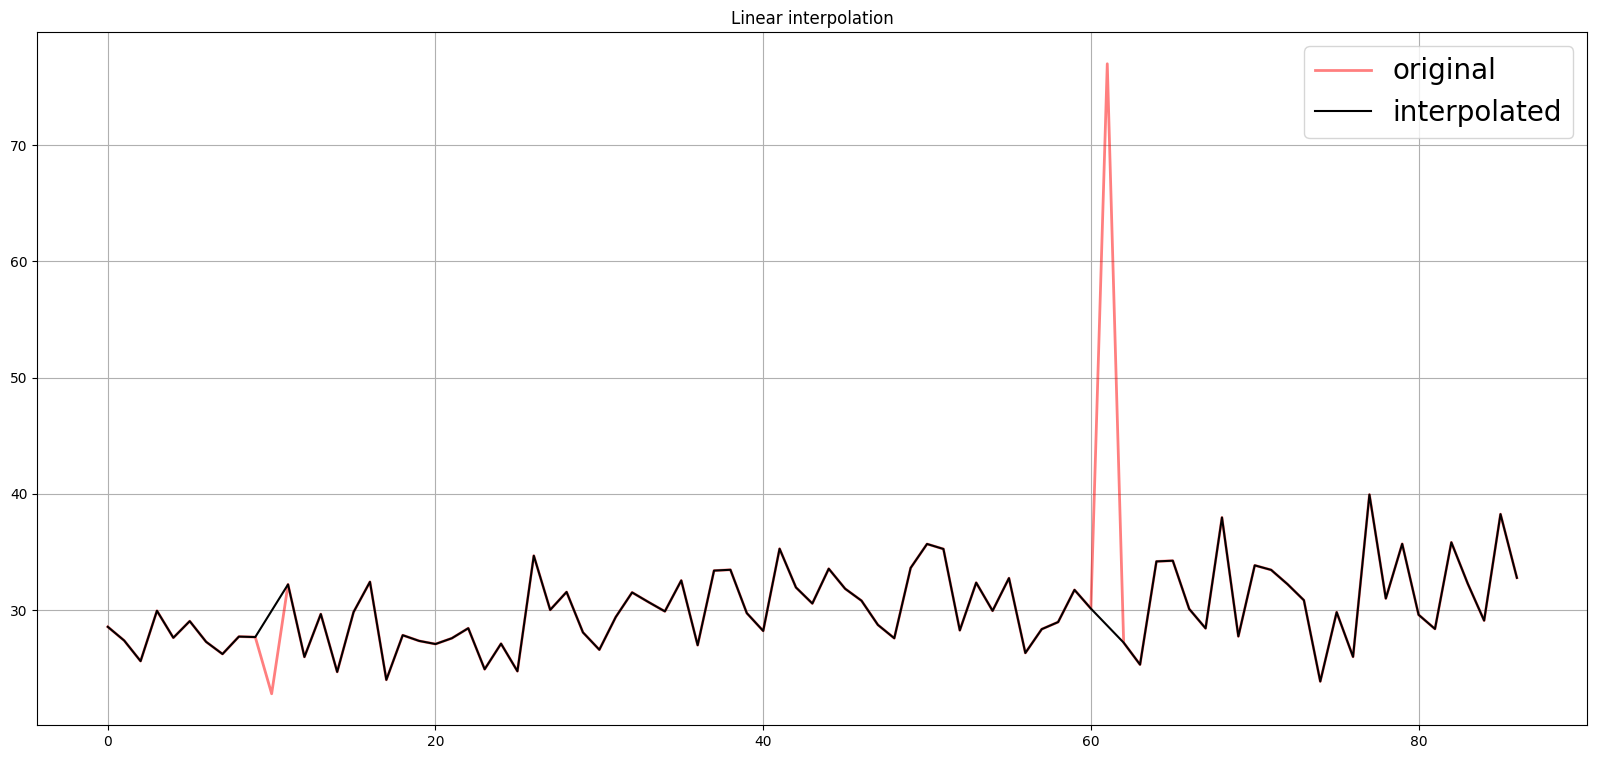

In [351]:
outliers_idx = dtf_outliers[dtf_outliers["outlier"]==1].index

ts_outliers_nan = local_df.copy()
ts_outliers_nan.loc[outliers_idx] = np.nan
ts_clean = ts_outliers_nan.interpolate(method="linear")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Linear interpolation", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()

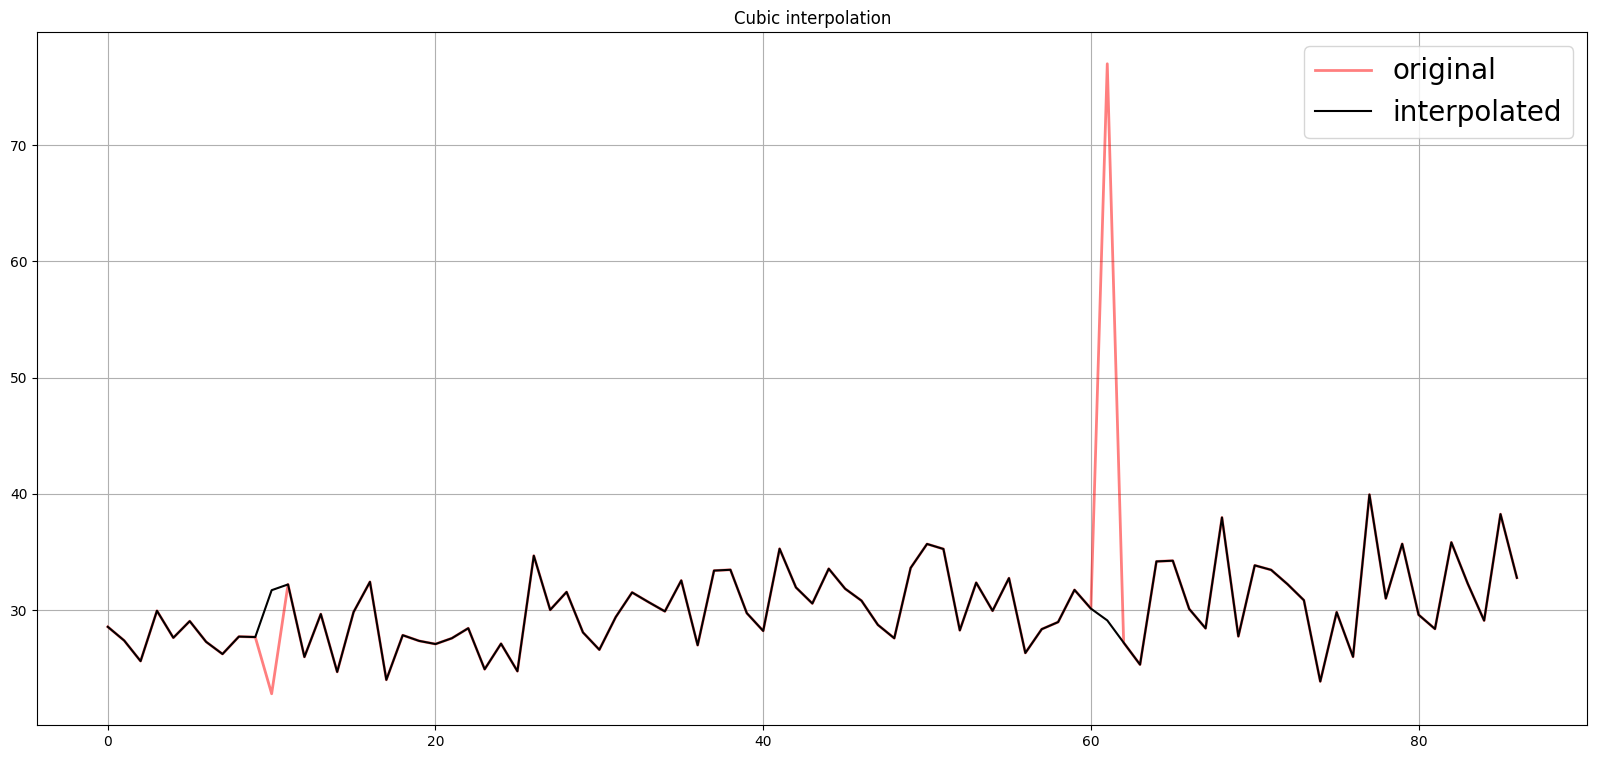

In [352]:
ts_outliers_nan = local_df.copy()
ts_outliers_nan.loc[outliers_idx] = np.nan
ts_clean = ts_outliers_nan.interpolate(method="cubic")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Cubic interpolation", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()

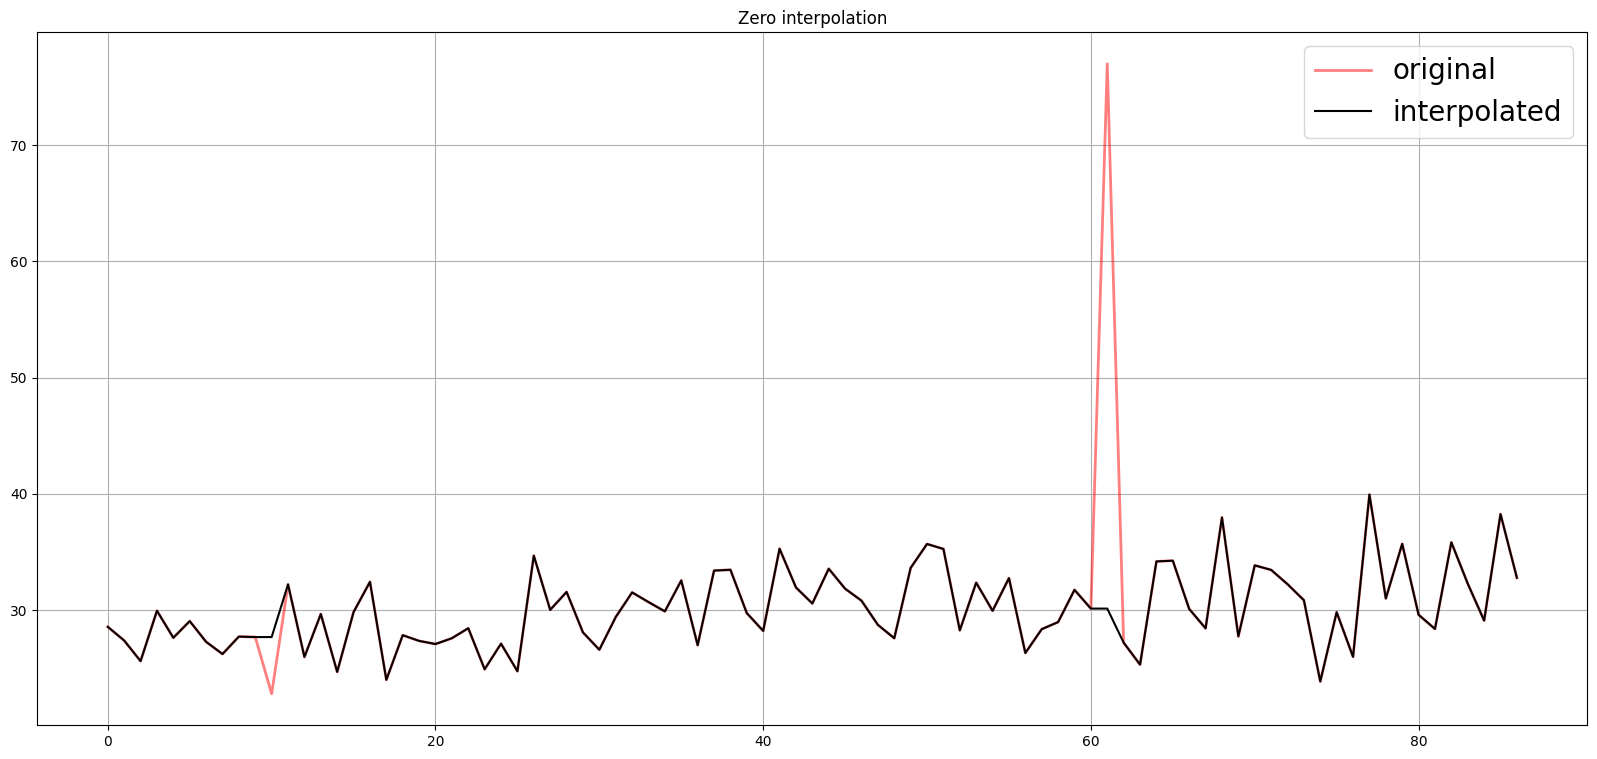

In [353]:
ts_outliers_nan = local_df.copy()
ts_outliers_nan.loc[outliers_idx] = np.nan
ts_clean = ts_outliers_nan.interpolate(method="zero")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Zero interpolation", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()